# Guided Semi-Supervised NMF for Email Sorting

This notebook contains code to predict whether or not a given email ilicits a response (1) or not (0).

In order to train our GSSNMF model, we used a subset of the Enron Dataset from Kaggle of 5000 emails. We hand labeled 1000 of the emails, 500 of which contribute to semi-supervising in the train set, the other 500 we use as our test set.

Our best results were acheived with the parameters and topic seed words in this notebook, but they can easily be changed.

All test print statements have been commented out, but can be uncommented for sanity checks





## 1. Importing Data

In order to run our notebook on our data, you will need two files:
- "train_4000.parquet" containing 4000 unlabeled and cleaned emails
- "test_df.xlsx" containing 1000 labeled and cleaned emails



In [ ]:
# necessary imports
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load in 2 data files as pandas dataframes
unlabeled = pd.read_parquet("/content/drive/My Drive/Math127 Final Project/train_4000.parquet")
labeled = pd.read_excel("/content/drive/My Drive/Math127 Final Project/test_df.xlsx")

# TESTS #
# print(unlabeled.keys())
# print(labeled.keys())

## 2. Create Data Matrix & Analyze Singular Values

In this section, we use the already pre-processed email data in order to create the Data Matrix for GSSNMF.

We will also analyze the data using Singular Value Decomposition (SVD) in order to determine an ideal number of topics to have our model learn.

In the first cell, please pick to use either Bag of Words or TF-IDF to represent the data. One of the two booleans should be set to true. There will be errors if both or none are set to true.

In [ ]:
# Set one of the two following booleans to True
tfidf = True
BoW = False

In [ ]:
# df1 contains unlabled email information
df1 = unlabeled.copy()
df1['email_id'] = range(len(df1))

# df2 contains labeled email information
df2 = labeled.copy()
df2 = df2.rename(columns={'Unnamed: 0': 'email_id'})

# Combine to get one dataframe with all emails
# Note: indices 0-3999 have no labels while 4000-4999 contain labels
full_df = pd.concat([df1, df2], ignore_index=True)

# create a list of all unique words in the emails
corpus = full_df['cleaned_body'].astype(str).tolist()

# Create X_full using the chosen tokenization method
if tfidf:
  vectorizer = TfidfVectorizer()
elif BoW:
  vectorizer = CountVectorizer()

X_full = vectorizer.fit_transform(corpus).toarray()  # BoW matrix:(num_docs, vocab_size)
idx_to_word = sorted(vectorizer.vocabulary_.keys(), key=lambda x: vectorizer.vocabulary_[x])

# Convert idx_to_word to a numpy array immediately
idx_to_word = np.array(idx_to_word)
# Calculate the sum of each column (word) in X
word_counts = X_full.sum(axis=0)

if tfidf:
  words_to_keep_indices = np.where(word_counts > 10)[0]
elif BoW:
  words_to_keep_indices = np.where(word_counts > 5)[0]

# Filter X to keep only columns corresponding to words that appear more than once
X_filtered = X_full[:, words_to_keep_indices]

# Filter idx_to_word to keep only the names of the words that appear more than once
idx_to_word_filtered = idx_to_word[words_to_keep_indices]

# Update X and idx_to_word to the filtered versions
X = X_filtered
idx_to_word = idx_to_word_filtered

X = X.T  # now shape = (vocab_size, num_docs)
vocab_size, num_docs = X.shape

print("X shape (words × docs):", X.shape)

X_train = X[:, :4500]
X_test  = X[:, 4500:]

X shape (words × docs): (533, 5000)


Singular values 's' (descending order) shape: (100,)
Left singular vectors 'u' shape: (533, 100)
Right singular vectors 'vt' shape: (100, 5000)


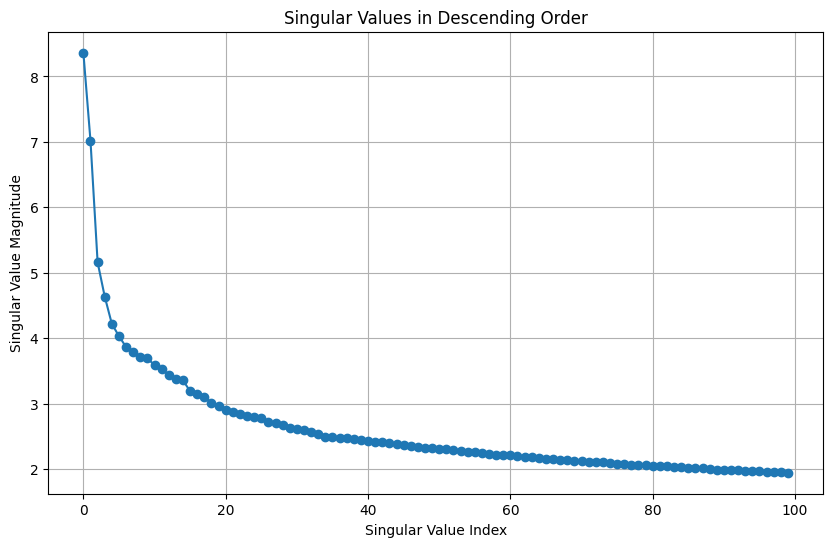

In [ ]:
sparse_matrix_df = csc_matrix(X)
u, s, vt = svds(sparse_matrix_df, k=100)

# Reverse the order of the singular values stored in s so they are in descending order
s = s[::-1]
u = u[:, ::-1]
vt = vt[::-1, :]

print("Singular values 's' (descending order) shape:", s.shape)
print("Left singular vectors 'u' shape:", u.shape)
print("Right singular vectors 'vt' shape:", vt.shape)

# Create a range for the x-axis (indices of singular values)
x_axis = np.arange(len(s))

# Plot the singular values
plt.figure(figsize=(10, 6))
plt.plot(x_axis, s, marker='o', linestyle='-')

# Add title and labels
plt.title('Singular Values in Descending Order')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')

# Display the plot
plt.grid(True)
plt.show()

## 3. Create Matrices for GSSNMF

In the first cell of this section:
- Choose number of learned topics (refer to SVD Section)
-  please set your chosen seed topics, in the form \{"word": 1\} (examples are provided). Make sure the number of given topics matches the "num_seed_topics" variable.

In [ ]:
num_topics = 10  # ideally use the elbow point from the SVD plot above
num_seed_topics = 2

# Create seed topics and Y matrix
seed_word1 = {"please": 1}
seed_word2 = {"respond": 1}
# seed_word3 = {"unsubscribe": 1}
# seed_word4 = {"forwarded": 1}
# seed_word5 = {"attached": 1}

gt_topic_words = [seed_word1, seed_word2]

In [ ]:
num_classes = 2  # "do not respond" / "respond"
num_train_docs = X_train.shape[1]

# Initialize
Z = np.zeros((num_classes, num_train_docs))
L = np.zeros((num_classes, num_train_docs))

# Only labeled rows in training set
labeled_train_df = full_df[full_df['labels'].isin([0, 1])]

# Only consider the first 4500 rows for training
for doc_idx in range(4500):
    label = full_df.iloc[doc_idx]['labels']  # correct!
    if label in [0, 1]:  # only valid labels
        label = int(label)
        Z[label, doc_idx] = 1
        L[label, doc_idx] = 1


vocab_size, num_train_docs = X_train.shape

np.random.seed(0)
W = np.random.rand(vocab_size, num_topics)        # words × topics
H = np.random.rand(num_topics, num_train_docs)    # topics × docs
B = np.random.rand(num_topics, num_seed_topics)   # topic supervision
C = np.random.rand(num_classes, num_topics)       # label dictionary

In [ ]:
def d_to_v(d, verbose=True):
    """
    Given dictionary d of form {word: weight}, created GT topic vector v. See writeup for details.
    """
    l = list(idx_to_word)
    v = np.zeros(idx_to_word.shape[0])

    for key in d.keys():
        i = l.index(key)
        if(i < 0):
            print("Could not find word '" + key + "' in list of words!")
        else:
            v[i] = d[key]

    return v

gt_topic_vectors= [d_to_v(x) for x in gt_topic_words]

Y = np.stack(gt_topic_vectors).T

## 4. Run GSSNMF

Below set the hyperparameters and number of iterations.
We recommend over 500 iterations for better results.

Once finished, view learned topics, see model predictions, and accuracy on test set.

In [ ]:
eps = 1e-12
lam = 0.2
mu = 0.001

iterations = 1500

for iter in range(iterations):
  W *= (X_train @ H.T + lam * (Y @ B.T)) / (W @ H @ H.T + lam * (W @ B @ B.T) + eps)
  H *= (W.T @ X_train + mu * C.T @ (L * L * Z)) / (W.T @ W @ H + mu * C.T @ (L * L * (C @ H)) + eps)
  B *= (W.T @ Y) / (W.T @ W @ B + eps)
  C *= ((L * Z) @ H.T) / ((L * L * (C @ H)) @ H.T + eps)

  if iter%100 == 0:
    print(iter, " iterations finished")


0  iterations finished
100  iterations finished
200  iterations finished
300  iterations finished
400  iterations finished
500  iterations finished
600  iterations finished
700  iterations finished
800  iterations finished
900  iterations finished
1000  iterations finished
1100  iterations finished
1200  iterations finished
1300  iterations finished
1400  iterations finished


In [ ]:
def show_topics(W, vocab, topn=15):
    """
    W: (n_words x n_topics) matrix
    vocab: list of words corresponding to rows of W
    topn: number of words per topic
    """
    n_topics = W.shape[1]

    for t in range(n_topics):
        print(f"\n=== Topic {t} ===")
        # get indices of the top words
        top_indices = np.argsort(W[:, t])[::-1][:topn]
        for idx in top_indices:
            print(f"{vocab[idx]:20s}  {W[idx, t]:.4f}")

show_topics(W, idx_to_word, topn=5)


=== Topic 0 ===
power                 0.0194
gas                   0.0184
energy                0.0164
trading               0.0093
california            0.0091

=== Topic 1 ===
kay                   0.0427
agreement             0.0084
ben                   0.0073
letter                0.0054
contract              0.0052

=== Topic 2 ===
know                  0.0152
meeting               0.0132
would                 0.0127
let                   0.0124
thanks                0.0117

=== Topic 3 ===
intended              0.0230
recipient             0.0200
may                   0.0117
use                   0.0116
corp                  0.0093

=== Topic 4 ===
perlingiere           0.0174
debra                 0.0169
america               0.0162
smith                 0.0162
fax                   0.0161

=== Topic 5 ===
deal                  0.0370
kate                  0.0204
thanks                0.0096
deals                 0.0095
chris                 0.0072

=== Topic 6 ===
attached   

In [ ]:
H_test = np.random.rand(W.shape[1], X_test.shape[1])  # topics × test_docs

iterations = 200

for iter in range(iterations):
  numerator = W.T @ X_test
  denominator = W.T @ W @ H_test + eps
  H_test *= numerator / denominator

test_df = full_df.iloc[4500:]

y_test_raw = test_df["labels"].copy()
valid_mask = y_test_raw.isin([0, 1])
true_test_labels = y_test_raw[valid_mask].astype(int).values

class_scores = C @ H_test
# print(class_scores)
pred_labels = np.argmax(class_scores, axis=0)
pred_labels = pred_labels[valid_mask]

print(pred_labels)
print(true_test_labels)
print(C)
print("Z sum:", np.sum(Z))  # should be >0 if labeled emails exist
print("L sum:", np.sum(L))


accuracy = np.mean(pred_labels == true_test_labels)
print("Test accuracy:", accuracy)

false_positive = 0
true_positive = 0
false_negative = 0
true_negative = 0
for pred, gt in zip(pred_labels, true_test_labels):
  if pred == 1 and gt == 0:
    false_positive += 1
  elif pred == 0 and gt == 1:
    false_negative += 1
  elif pred == 1 and gt == 1:
    true_positive += 1
  else:
    true_negative += 1

print("False positives:", false_positive)
print("False negatives:", false_negative)
print("True positives:", true_positive)
print("True negatives:", true_negative)

[0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1
 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0
 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1
 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0
 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1
 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0
 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1
 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0
 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1
 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1
 0 0 0 0 1 1 1 1 0 1 1 0 